<a href="https://colab.research.google.com/github/muhafidz-ahmad/bilstm-keras-text-classification/blob/main/Covid_19_Tweet_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Preparation

In [ ]:
import string
import re

import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load Data

Dataset obtained from https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

In [ ]:
df1 = pd.read_csv('/content/Corona_NLP_train.csv', encoding='latin1')
df2 = pd.read_csv('/content/Corona_NLP_test.csv')
df = pd.concat([df1, df2])
df = df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
for i in range(0,len(df)):
    if(df['Sentiment'].iloc[i]=='Extremely Negative'):
        df['Sentiment'].iloc[i]='Negative'
    elif(df['Sentiment'].iloc[i]=='Extremely Positive'):
        df['Sentiment'].iloc[i]='Positive'

df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  44955 non-null  object
 1   Sentiment      44955 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [ ]:
df_label = pd.get_dummies(df['Sentiment'])
df_clear = pd.concat([df['OriginalTweet'], df_label],
                     axis=1)
df_clear.head()

,OriginalTweet,Negative,Neutral,Positive
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,1,0
1,advice Talk to your neighbours family to excha...,0,0,1
2,Coronavirus Australia: Woolworths to give elde...,0,0,1
3,My food stock is not the only one which is emp...,0,0,1
4,"Me, ready to go at supermarket during the #COV...",1,0,0


In [ ]:
sentiment_list = df['Sentiment'].unique()

tweet = df_clear['OriginalTweet'].values
sentiment = df_clear[sentiment_list].values

tweet[:2]

array(['@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8',
       'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'],
      dtype=object)

# Text Preprocessing

In [ ]:
nltk.download('stopwords')

stop_words = stopwords.words('english')

clear_tweet = []

for i, text in enumerate(tweet):
    lower_text = text.lower()
    
    #remove punctuation
    del_punc = "".join([char for char in lower_text if char not in string.punctuation])
    
    # remove url
    del_url = re.sub(r"http\S+", "", del_punc)

    # remove stopword
    del_stopword = " ".join([word for word in del_url.split() if word not in stop_words])

    # remove whitespace
    del_whitespace = " ".join(del_stopword.split())

    clear_tweet.append(del_whitespace)

clear_tweet = np.array(clear_tweet)
clear_tweet[:2]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array(['menyrbie philgahan chrisitv',
       'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'],
      dtype='<U286')

# Split Data Train and Data Test

In [ ]:
tweet_train, tweet_test, y_train, y_test = train_test_split(clear_tweet,
                                                            sentiment,
                                                            test_size=0.2,
                                                            random_state=1)

# Tokenizer

In [ ]:
NUM_WORDS = 15000

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<oov>')

tokenizer.fit_on_texts(tweet_train)

seq_train = tokenizer.texts_to_sequences(tweet_train)
seq_test = tokenizer.texts_to_sequences(tweet_test)

x_train = pad_sequences(seq_train, padding='post', truncating='post')
x_test = pad_sequences(seq_test, padding='post', truncating='post')

print(len(tokenizer.word_index))
print(x_train.max())
print(len(x_test[0]))

57804
14999
46


{'Neutral': 6670, 'Positive': 15671, 'Negative': 13623}
{'Neutral': 1662, 'Positive': 3921, 'Negative': 3408}


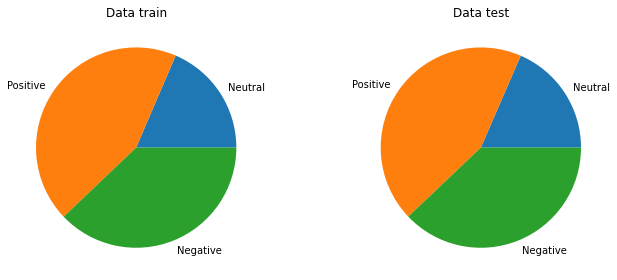

In [ ]:
sentiment_counts_train = {}
sentiment_counts_test = {}

for i in range(3):
    value_train = pd.DataFrame(y_train)[i].value_counts().iloc[1]
    key_train = sentiment_list[i]
    sentiment_counts_train[key_train] = value_train

    value_test = pd.DataFrame(y_test)[i].value_counts().iloc[1]
    key_test = sentiment_list[i]
    sentiment_counts_test[key_test] = value_test

fig, ax = plt.subplots(1, 2, figsize = (10,4))

ax[0].pie(sentiment_counts_train.values(),
          labels=sentiment_counts_train.keys())
ax[0].set_title('Data train')

ax[1].pie(sentiment_counts_test.values(),
          labels=sentiment_counts_test.keys())
ax[1].set_title('Data test')

fig.tight_layout()
plt.show

print(sentiment_counts_train)
print(sentiment_counts_test)

# Build The Model

In [ ]:
highest_acc_train = [0,0]
highest_acc_test = [0,0]

class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        global highest_acc_train, highest_acc_test

        target_acc = 0.85

        if logs.get('acc') > target_acc and logs.get('val_acc') > target_acc:
            print("\nThe accuracy has reached >", target_acc)
            self.model.stop_training = True
        if logs.get('acc') > highest_acc_train[0]:
            highest_acc_train[0] = logs.get('acc')
            highest_acc_train[1] = epoch+1
        if logs.get('val_acc') > highest_acc_test[0]:
            highest_acc_test[0] = logs.get('val_acc')
            highest_acc_test[1] = epoch+1
            
early_stopping = keras.callbacks.EarlyStopping(patience=3, 
                                               monitor='val_acc',
                                               min_delta=0.01,
                                               verbose=1)

callbacks = myCallback()


model = models.Sequential([
    layers.Embedding(input_dim=NUM_WORDS, output_dim=32),
    layers.LSTM(16, dropout=0.6),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(sentiment_list), activation='softmax')
])

model.summary()

model.compile(loss=losses.CategoricalCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.003),
              metrics=['acc'])

hist = model.fit(x_train, y_train,
                 epochs=10,
                 batch_size=256,
                 validation_data=(x_test, y_test),
                 verbose=2,
                 callbacks=[callbacks])

print("\nHighest training accuracy: %.4f | epoch: %i"%(highest_acc_train[0], 
                                                       highest_acc_train[1]))
print("Highest validation accuracy: %.4f | epoch: %i"%(highest_acc_test[0],
                                                       highest_acc_test[1]))

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_73 (Embedding)    (None, None, 32)          480000    
                                                                 
 lstm_74 (LSTM)              (None, 16)                3136      
                                                                 
 dense_156 (Dense)           (None, 16)                272       
                                                                 
 dropout_76 (Dropout)        (None, 16)                0         
                                                                 
 dense_157 (Dense)           (None, 3)                 51        
                                                                 
Total params: 483,459
Trainable params: 483,459
Non-trainable params: 0
_________________________________________________________________
Epoch 1/45
141/141 - 3s - loss: 1.0238 - acc: 0

# Plot the Result

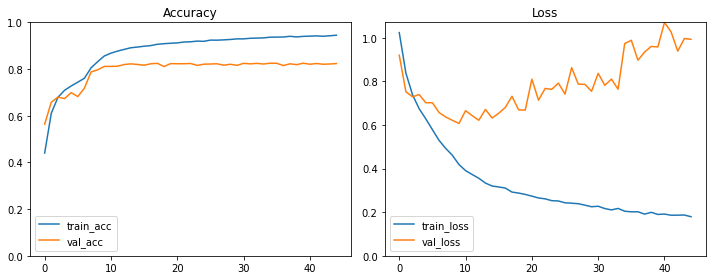

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))

ax[0].plot(hist.history['acc'], label = 'train_acc')
ax[0].plot(hist.history['val_acc'], label = 'val_acc')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_ylim(0, 1)

ax[1].plot(hist.history['loss'], label = 'train_loss')
ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].legend()
ax[1].set_title('Loss')
ax[1].set_ylim([0,max(hist.history['loss'] + hist.history['val_loss'])])

fig.tight_layout()
plt.show()